## 특정 위치 예보 데이터 크롤링 및 엑셀 저장 자동화

In [2]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from webdriver_manager.chrome import ChromeDriverManager
import pandas as pd
import time
from selenium.webdriver.common.action_chains import ActionChains

def get_weather_info_dynamic():
    # Selenium WebDriver 설정
    service = Service(ChromeDriverManager().install())
    driver = webdriver.Chrome(service=service)
    driver.maximize_window()  # 창 최대화

    # URL 접속
    url = "https://www.weather.go.kr/w/weather/forecast/short-term.do"
    driver.get(url)

    time.sleep(5)  # 페이지 로드 대기

    weather_data = []
    # 검색어 입력
    global search_query 
    search_query = input("검색어를 입력하세요: ")
    input_selector = "input.input"
    input_element = WebDriverWait(driver, 10).until(
        EC.presence_of_element_located((By.CSS_SELECTOR, input_selector))
    )
    input_element.click()  # 입력 필드 클릭
    input_element.send_keys(search_query)  # 검색어 입력
    input_element.send_keys(Keys.ENTER)  # 엔터 입력

    time.sleep(2)  # 엔터 후 대기

    # 탭 키 3번 동작 (ActionChains 활용)
    actions = ActionChains(driver)
    for _ in range(3):
        actions.send_keys(Keys.TAB)
        time.sleep(1)
    actions.send_keys(Keys.ENTER)
    actions.perform()  # 동작 실행

    time.sleep(5)  # 최종 결과 대기

    for i in range(11):  # 1번째와 2번째 슬라이드 선택
        # 동적으로 날짜 선택
        date_selector = f"#digital-forecast div.dfs-daily-slide-wrap > div:nth-child({i + 1}) h4 > span:nth-child(1)"
        date_element = driver.find_element(By.CSS_SELECTOR, date_selector)
        date_text = date_element.text.strip() if date_element else "날짜 정보 없음"

        # 동적으로 최저 기온 선택
        min_temp_selector = f"#digital-forecast div.dfs-daily-slide-wrap > div:nth-child({i + 1}) div.daily-minmax > div:nth-child(1) > span"
        min_temp_element = driver.find_element(By.CSS_SELECTOR, min_temp_selector)
        min_temp_text = min_temp_element.text.strip() if min_temp_element else "최저 기온 정보 없음"

        # 동적으로 최고 기온 선택
        max_temp_selector = f"#digital-forecast div.dfs-daily-slide-wrap > div:nth-child({i + 1}) div.daily-minmax > div:nth-child(2) > span"
        max_temp_element = driver.find_element(By.CSS_SELECTOR, max_temp_selector)
        max_temp_text = max_temp_element.text.strip() if max_temp_element else "최고 기온 정보 없음"

        # 데이터 저장
        weather_data.append({
            "날짜": date_text,
            "최저 기온": min_temp_text,
            "최고 기온": max_temp_text
        })

    # WebDriver 종료
    #driver.quit()

    return weather_data

def save_to_excel(data, file_name="weather_data.xlsx"):
    # 데이터프레임 생성
    df = pd.DataFrame(data)
    # 엑셀 파일로 저장
    df.to_excel(file_name, index=False)
    print(f"데이터가 {file_name}에 저장되었습니다.")

# 실행 및 출력
data = get_weather_info_dynamic()
for weather in data:
    print(f"날짜: {weather['날짜']}, 최저 기온: {weather['최저 기온']}, 최고 기온: {weather['최고 기온']}")

save_to_excel(data)

날짜: 28일, 최저 기온: -7℃, 최고 기온: 1℃
날짜: 29일, 최저 기온: -4℃, 최고 기온: 4℃
날짜: 30일, 최저 기온: 0℃, 최고 기온: 10℃
날짜: 31일, 최저 기온: -4℃, 최고 기온: 3℃
날짜: 1일, 최저 기온: -4℃, 최고 기온: 6℃
날짜: 2일, 최저 기온: -3℃, 최고 기온: 3℃
날짜: 3일, 최저 기온: -5℃, 최고 기온: 2℃
날짜: 4일, 최저 기온: -5℃, 최고 기온: 2℃
날짜: 5일, 최저 기온: -5℃, 최고 기온: 2℃
날짜: 6일, 최저 기온: -4℃, 최고 기온: 3℃
날짜: 7일, 최저 기온: -4℃, 최고 기온: 3℃
데이터가 weather_data.xlsx에 저장되었습니다.


## 기온에 따른 빙결 위험 등급 분석 및 시각화

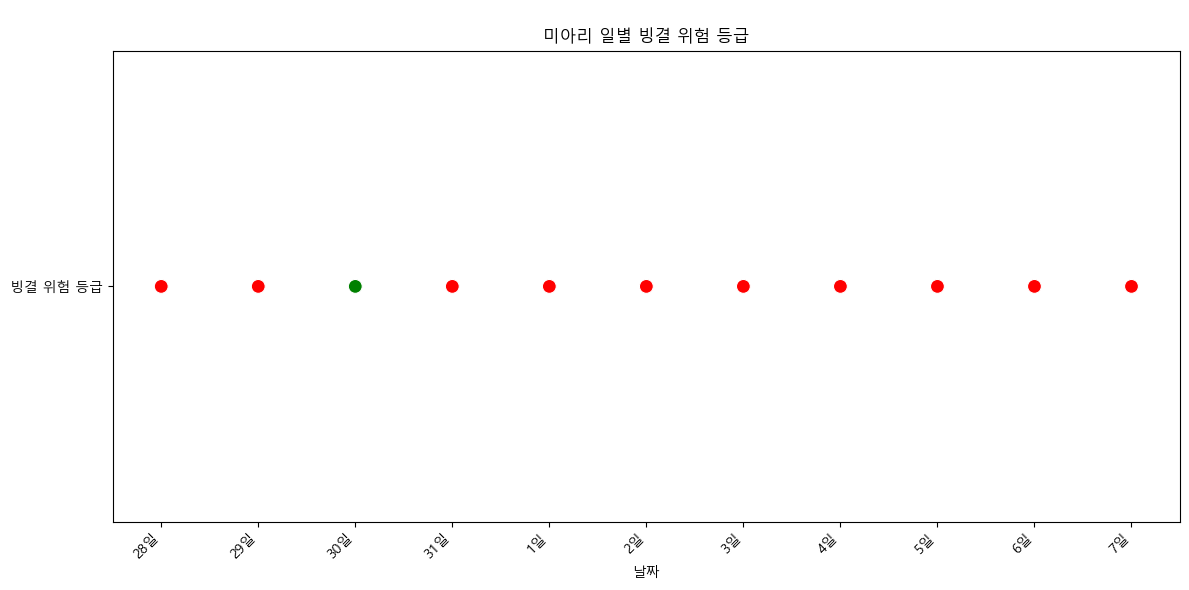

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

# pickle 파일 로드
with open("temperature_data.pkl", "rb") as f:
    data = pickle.load(f)

temp_00 = data["temp_00"] #저위험
temp_01 = data["temp_01"] #위험

# 엑셀에서 데이터 불러오기
def load_weather_data(file_name="weather_data.xlsx"):
    df = pd.read_excel(file_name)
    return df
# 기온에 따른 빙결 위험 등급을 반환하는 함수
def categorize_freezing_risk(temp):
    try:
        # 기온에서 숫자만 추출 (℃ 기호 등 제거)
        temp = float(str(temp).replace('℃', '').replace('°', '').strip())
        if temp < temp_01:
            return 'J', 'red'  # J (빨강): -5도 미만
        elif temp_01 <= temp < temp_00:
            return 'F', 'green'  # F (초록): 0도 ~ -5도
        elif temp >= temp_00:
            return 'B', 'blue'  # B (파랑): 0도 이상
    except (ValueError, TypeError):
        return '정보 없음', 'gray'  # 기온 정보가 없거나 변환 실패할 경우

#기온에 따른 빙결 위험 등급을 시각화하는 함수
def visualize_weather(df):
    dates = []
    freezing_risks = []
    colors = []

    for index, row in df.iterrows():
        date = row["날짜"]
        min_temp = row["최저 기온"]
        # 최저 기온을 기준으로 위험 등급을 매기기
        grade, color = categorize_freezing_risk(min_temp)
        dates.append(date)
        freezing_risks.append(grade)
        colors.append(color)

    # 시각화
    df["빙결 위험 등급"] = freezing_risks
    df["색상"] = colors

    # 시각화
    # 한글 폰트 설정
    plt.rcParams['font.family'] = 'Malgun Gothic'  # Windows용
    plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 제대로 표시
    plt.figure(figsize=(12, 6))
    sns.scatterplot(x="날짜", y=["빙결 위험 등급"]*len(df), data=df, hue="빙결 위험 등급", palette={"J": "red", "F": "green", "B": "blue", "정보 없음": "gray"}, s=100, legend=None)
    plt.xticks(rotation=45, ha='right')
    plt.title(f"\n{search_query} 일별 빙결 위험 등급")
    plt.xlabel("날짜")
    plt.ylabel("")
    plt.tight_layout()
    plt.show()

# 실행 및 출력
df = load_weather_data()  # 엑셀에서 데이터 불러오기
visualize_weather(df)  # 시각화

## 특정 도로 블랙아이스 예보: 기온에 따른 빙결 위험군 분석 및 시각화

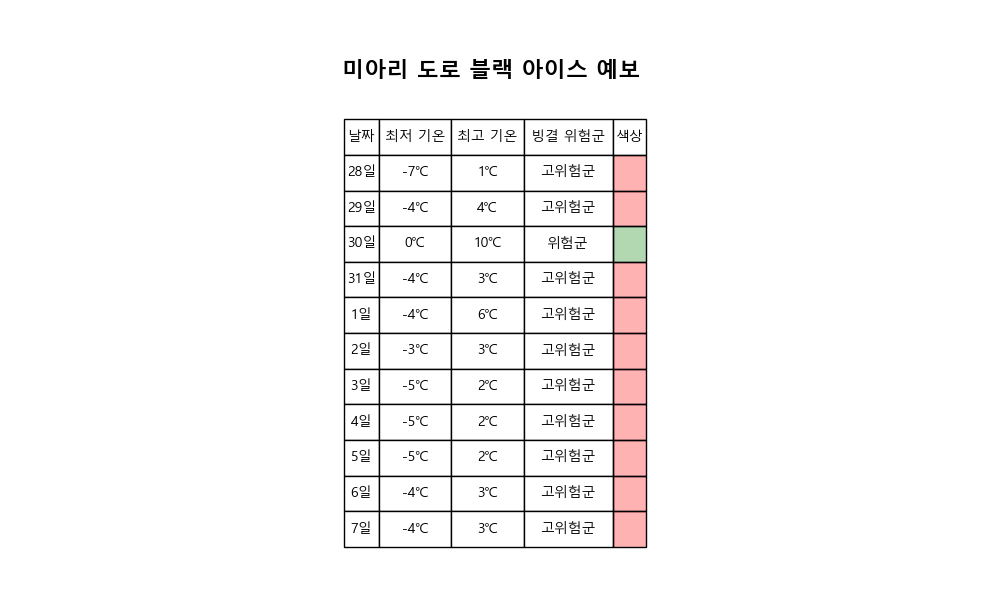

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
import pickle

# pickle 파일 로드
with open("temperature_data.pkl", "rb") as f:
    data = pickle.load(f)

temp_00 = data["temp_00"] #저위험
temp_01 = data["temp_01"] #위험

# 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'  # Windows용
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 제대로 표시

# 엑셀에서 데이터 불러오기
def load_weather_data(file_name="weather_data.xlsx"):
    df = pd.read_excel(file_name)
    return df

def categorize_freezing_risk(temp):
    """기온에 따른 빙결 위험 등급을 반환하는 함수"""
    try:
        # 기온에서 숫자만 추출 (℃ 기호 등 제거)
        temp = float(str(temp).replace('℃', '').replace('°', '').strip())
        if temp < temp_01:
            return '고위험군', mcolors.to_rgba('red', alpha=1)  # 연한 빨강
        elif temp_01 <= temp < temp_00:
            return '위험군', mcolors.to_rgba('green', alpha=1)  # 연한 초록
        elif temp >= temp_00:
            return '저위험군', mcolors.to_rgba('blue', alpha=1)  # 연한 파랑
    except (ValueError, TypeError):
        return '정보 없음', mcolors.to_rgba('gray', alpha=1)  # 연한 회색

def visualize_weather_table(df, search_query):
    """기온에 따른 빙결 위험 등급을 표로 시각화하는 함수"""
    # 날짜, 최저 기온, 빙결 위험 등급 열 생성
    dates = []
    min_temps = []
    freezing_risks = []
    colors = []  # 색상 리스트

    for index, row in df.iterrows():
        date = row["날짜"]
        min_temp = row["최저 기온"]
        
        # "정보 없음"이 아니면 기온을 기준으로 빙결 위험 등급을 매김
        grade, color = categorize_freezing_risk(min_temp)
        dates.append(date)
        min_temps.append(min_temp)
        freezing_risks.append(grade)
        colors.append(color)

    # 데이터프레임에 결과 저장
    df["최저 기온"] = min_temps
    df["빙결 위험군"] = freezing_risks
    df["색상"] = colors  # 색상 열 추가

    # 표 출력
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # 각 행에 대해 색상을 지정
    cell_colors = []
    for i, color in enumerate(colors):
        row_color = ['white', 'white', 'white', color]  # 색상은 마지막 열에만 적용
        cell_colors.append(row_color)

    # 표 그리기
    ax.axis('off')  # 표 주위에 축을 제거
    table = ax.table(cellText=df.values,
                    colLabels=df.columns,
                    loc="center", cellLoc="center")
    
    # 행 간 간격 조정
    table.scale(1, 2.0)  # 행 높이를 두 배로 설정

    # 셀 색상 설정
    for (row, col), cell in table.get_celld().items():
        if row > 0 and col == 4:  # 데이터 행의 "색상" 열에만 색상 적용
            grade_color = {'고위험군': mcolors.to_rgba('red', alpha=0.3),
                           '위험군': mcolors.to_rgba('green', alpha=0.3),
                           '저위험군': mcolors.to_rgba('blue', alpha=0.3)}.get(df.iloc[row - 1]['빙결 위험군'], mcolors.to_rgba('gray', alpha=0.3))
            cell.set_facecolor(grade_color)
            cell.set_text_props(text="")  # 텍스트 제거

    # 폰트 크기 설정
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.auto_set_column_width(col=list(range(len(df.columns))))

    # 그래프 제목 설정
    title = f"\n\n{search_query} 도로 블랙 아이스 예보 "
    plt.title(title, fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()                  

# 실행 및 출력
# search_query = "서울 지역"  # 검색어 예시
df = load_weather_data()  # 엑셀에서 데이터 불러오기
visualize_weather_table(df, search_query)  # 시각화


## 도로블랙아이스_중기예보_분석_이메일전송

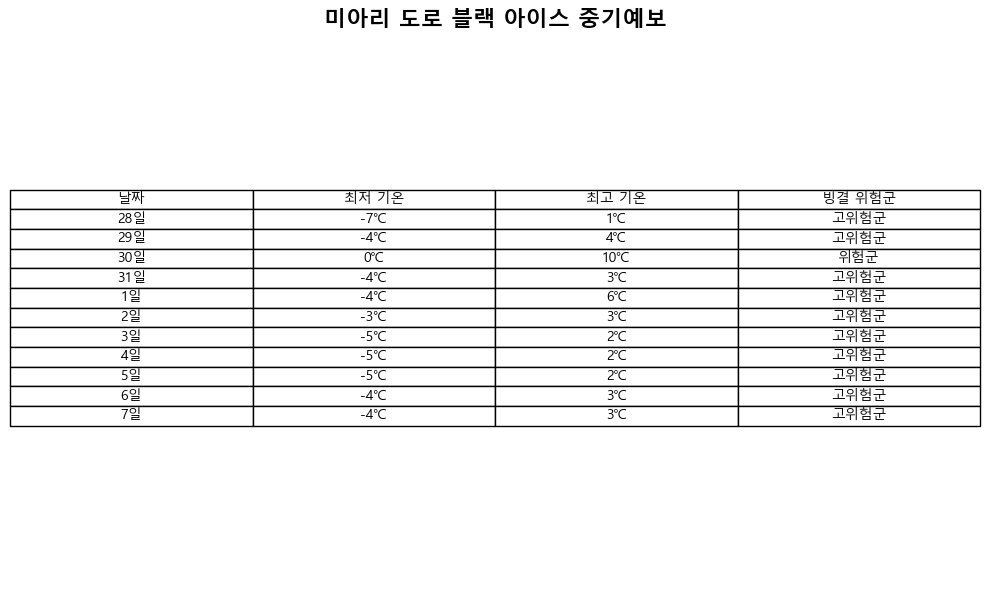

[에러] 이메일 전송 실패: {'': (555, b'5.5.2 Syntax error, cannot decode response. For more information, go to\n5.5.2  https://support.google.com/a/answer/3221692 and review RFC 5321\n5.5.2 specifications. 41be03b00d2f7-842aba72f71sm14077187a12.9 - gsmtp')}


In [12]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
import smtplib
from email.mime.text import MIMEText
from email.mime.multipart import MIMEMultipart
import pickle

# pickle 파일 로드
with open("temperature_data.pkl", "rb") as f:
    data = pickle.load(f)

temp_00 = data["temp_00"] #저위험
temp_01 = data["temp_01"] #위험

# 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'  # Windows용
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 제대로 표시

# 엑셀에서 데이터 불러오기
def load_weather_data(file_name="weather_data.xlsx"):
    df = pd.read_excel(file_name)
    return df

def categorize_freezing_risk(temp):
    """기온에 따른 빙결 위험 등급을 반환하는 함수"""
    try:
        temp = float(str(temp).replace('℃', '').replace('°', '').strip())
        if temp < temp_01:
            return '고위험군', mcolors.to_rgba('red', alpha=1)
        elif temp_01 <= temp < temp_00:
            return '위험군', mcolors.to_rgba('green', alpha=1)
        elif temp >= temp_00:
            return '저위험군', mcolors.to_rgba('blue', alpha=1)
    except (ValueError, TypeError):
        return '정보 없음', mcolors.to_rgba('gray', alpha=1)

def visualize_weather_table(df, search_query):
    """기온에 따른 빙결 위험 등급을 표로 시각화하는 함수"""
    dates, min_temps, freezing_risks, colors = [], [], [], []
    
    for _, row in df.iterrows():
        date = row["날짜"]
        min_temp = row["최저 기온"]
        grade, color = categorize_freezing_risk(min_temp)
        dates.append(date)
        min_temps.append(min_temp)
        freezing_risks.append(grade)
        colors.append(color)

    df["빙결 위험군"] = freezing_risks

    # 시각화
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.axis('off')
    table = ax.table(cellText=df.values, colLabels=df.columns, loc="center", cellLoc="center")
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    plt.title(f"{search_query} 도로 블랙 아이스 중기예보", fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

    return df  # 시각화 후 데이터프레임 반환

def send_email_alert(receiver_email, subject, body):
    """이메일 전송 함수"""
    sender_email = "lkj10009@gmail.com"
    sender_password = "qrwb pfqr fncf vhdr"  # 앱 비밀번호

    msg = MIMEMultipart()
    msg['From'] = sender_email
    msg['To'] = receiver_email
    msg['Subject'] = subject
    msg.attach(MIMEText(body, 'plain'))

    try:
        with smtplib.SMTP('smtp.gmail.com', 587) as server:
            server.starttls()
            server.login(sender_email, sender_password)
            server.sendmail(sender_email, receiver_email, msg.as_string())
            print(f"[알림] 이메일 전송 성공! ({receiver_email})")
    except Exception as e:
        print(f"[에러] 이메일 전송 실패: {e}")

# 실행 코드
file_name = "weather_data.xlsx"  # 엑셀 파일 경로
receiver_email = input("수신자 이메일 주소를 입력하세요: ")
subject = f"{search_query} 도로 블랙 아이스 중기예보 결과"
body = ""

try:
    df = load_weather_data(file_name)
    result_df = visualize_weather_table(df, search_query)

    # 결과를 텍스트로 변환
    body += f"{search_query} 도로 블랙 아이스 중기예보 결과:\n\n"
    body += result_df.to_string(index=False)  # 데이터프레임을 텍스트로 변환

    send_email_alert(receiver_email, subject, body)
except FileNotFoundError:
    print("[에러] 엑셀 파일을 찾을 수 없습니다. 파일 경로를 확인하세요.")
except Exception as e:
    print(f"[에러] 실행 중 문제가 발생했습니다: {e}")
